# Libraries / Settings

#### Libraries

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Clustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans

# Results
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualizations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import pylab as py
from tqdm import tqdm

# Web interface
from urllib.request import urlopen
import json

# Misc
import time
from IPython.display import clear_output
from pygame import mixer

pygame 2.1.3 (SDL 2.0.22, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Settings for notebook

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

salty_data = 'C:/Users/nuke2/Desktop/Python/Projects/Data/SaltyBetter/salty_data_complete.csv' # Desktop
# salty_data = 'C:/Users/nuke2/Desktop/Python/Projects/Data/SaltyBetter/salty_data_complete.csv' # Laptop

# SaltyData API
match_url = "https://salty-boy.com/current-match"

# Set test-train split percentages
test_train_split_percentage = 0.2
train_validation_split_percentage = 0.2

# Set notebook seed
notebook_seed = 550

# Load notification sound
mixer.init()
mixer.music.load(r'C:\Users\nuke2\Desktop\Python\Projects\SaltyBetter\mixkit-gaming-lock-2848.wav')

# Data cleaning

#### Read data/drop unnecessary columns

In [3]:
# Read data into df_all
df = pd.read_csv(salty_data, low_memory=False)
df_all = df.copy()

# Drop unnecessary columns
df_all.drop(columns=[
    'name',
#     'id', # Need for fighter clustering
    'prev_tier', # Dropped because duplicates
    'fighter_blue',
    'fighter_red',
    'bet_blue',
    'bet_red',
    'match_id',
    'streak_blue',
    'streak_red',
    'winner',
    'away',
    'name_other',
#     'id_other', # Need for fighter clustering
    'prev_tier_other', # Dropped because duplicates
], inplace=True)

# Print details about df_all
print(f"Num rows where elo != tier elo") 
print(f" -- Home: {sum(df_all.elo != df_all.tier_elo)}")
print(f" -- Other: {sum(df_all.elo_other != df_all.tier_elo_other)}")

df_all.head()

Num rows where elo != tier elo
 -- Home: 94447
 -- Other: 94062


,id,best_streak,elo,tier,tier_elo,average_bet,total_matches,win_rate,match_format,match_tier,winner_binary,id_other,best_streak_other,elo_other,tier_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other
0,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,0.0,803.0,2.0,1338.0,S,1338.0,4979841.32,37.0,0.27
1,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,0.0,884.0,14.0,1544.0,S,1433.0,4989952.13,39.0,0.64
2,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,1.0,6375.0,14.0,1702.0,S,1699.0,18188514.31,42.0,0.79
3,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,1.0,769.0,9.0,1623.0,S,1620.0,8723817.10,50.0,0.70
4,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,0.0,1490.0,6.0,1587.0,S,1586.0,7656194.80,55.0,0.64


#### One-hot encode categorical columns

In [4]:
# define a list of columns to one-hot encode
cols_to_encode = ["tier", "match_format", "match_tier", "tier_other"]

# apply one-hot encoding to the selected columns
df_all = pd.get_dummies(df_all, columns=cols_to_encode)

# Drop extra columns
# df_all.drop(columns=[
#     'tier_X', 
#     'tier_other_X', 
#     'match_format_matchmaking', 
#     'match_tier_X'
# ], inplace=True)

#### Copy df_all for Fighter Clustering

In [5]:
df_all_fighter_clustering = df_all.copy()
df_all.drop(columns=['id', 'id_other'], inplace=True)

#### Test train validation split data

In [6]:
# split the dataframe into training, validation, and testing sets
df_train, df_test = train_test_split(df_all, test_size=test_train_split_percentage, 
                                     random_state=notebook_seed)
df_train, df_val = train_test_split(df_train, test_size=train_validation_split_percentage, 
                                    random_state=notebook_seed)

# Get clustering dataframes
df_train_match_clustering_analysis = df_train.copy()
df_val_match_clustering_analysis = df_val.copy()
df_test_match_clustering_analysis = df_test.copy()

#### Standardize data

In [7]:
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,winner_binary,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
57742,2,1355,1355,4949849.05,38,0.29,1.0,4.0,1405.0,1405.0,7383242.82,50.0,0.40,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
28263,5,1552,1550,6610226.85,52,0.54,0.0,4.0,1326.0,1324.0,5415049.47,51.0,0.35,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
73794,2,1323,1316,5947170.24,50,0.28,0.0,4.0,1337.0,1332.0,4026818.54,50.0,0.30,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
104820,5,1617,1625,5060816.14,36,0.67,0.0,4.0,1514.0,1517.0,5181322.74,34.0,0.50,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
70754,3,1388,1391,3999576.38,24,0.29,1.0,6.0,1564.0,1565.0,6695553.45,31.0,0.65,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [8]:
# fit the scaler on the training data
scaler = MinMaxScaler()
scaler.fit(df_train)

# transform the data
df_train = pd.DataFrame(scaler.transform(df_train), columns=df_all.columns)
df_val = pd.DataFrame(scaler.transform(df_val), columns=df_all.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_all.columns)

# extract y test train validation sets
y_train = df_train.winner_binary
y_val = df_val.winner_binary
y_test = df_test.winner_binary

# Drop win column from feature dataframes
df_train = df_train.drop(columns=['winner_binary'])
df_val = df_val.drop(columns=['winner_binary'])
df_test = df_test.drop(columns=['winner_binary'])

In [9]:
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
0,0.283186,0.244477,0.245588,0.009524,0.440476,0.29,0.281818,0.320000,0.321006,0.019995,0.569767,0.40,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.309735,0.534610,0.532353,0.012758,0.607143,0.54,0.281818,0.202963,0.201183,0.014244,0.581395,0.35,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.283186,0.197349,0.188235,0.011466,0.583333,0.28,0.281818,0.219259,0.213018,0.010187,0.569767,0.30,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.309735,0.630339,0.642647,0.009740,0.416667,0.67,0.281818,0.481481,0.486686,0.013561,0.383721,0.50,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.292035,0.293078,0.298529,0.007673,0.273810,0.29,0.300000,0.555556,0.557692,0.017986,0.348837,0.65,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
print(f"Shape of training df: {df_train.shape}")

Shape of training df: (77123, 29)


#### Select Columns

In [11]:
# machine_learning_columns is a general selection of all columns that can be used for machine learning
machine_learning_columns = [
    # Home fighter
    'best_streak',
    'elo',
    'tier_A',
    'tier_B',
    'tier_P',
    'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
    'tier_other_A',
    'tier_other_B',
    'tier_other_P',
    'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
    'match_format_tournament',
    'match_tier_A',
    'match_tier_B',
    'match_tier_P',
    'match_tier_S',
#     'match_tier_X', # Most common category
]

# Clustering

### Match Clustering

#### K-Means Clustering

In [12]:
# Column selection for match k-means
match_clustering_columns = [
    # Home fighter
    'best_streak',
    'elo',
#     'tier_A',
#     'tier_B',
#     'tier_P',
#     'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
#     'tier_other_A',
#     'tier_other_B',
#     'tier_other_P',
#     'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
#     'match_format_tournament',
#     'match_tier_A',
#     'match_tier_B',
#     'match_tier_P',
#     'match_tier_S',
#     'match_tier_X', # Most common category
]

# Set columns above
df_match_clustering = df_train.copy()
df_match_clustering = df_match_clustering[match_clustering_columns]
df_match_clustering.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other
0,0.283186,0.244477,0.245588,0.009524,0.440476,0.29,0.281818,0.320000,0.321006,0.019995,0.569767,0.40
1,0.309735,0.534610,0.532353,0.012758,0.607143,0.54,0.281818,0.202963,0.201183,0.014244,0.581395,0.35
2,0.283186,0.197349,0.188235,0.011466,0.583333,0.28,0.281818,0.219259,0.213018,0.010187,0.569767,0.30
3,0.309735,0.630339,0.642647,0.009740,0.416667,0.67,0.281818,0.481481,0.486686,0.013561,0.383721,0.50
4,0.292035,0.293078,0.298529,0.007673,0.273810,0.29,0.300000,0.555556,0.557692,0.017986,0.348837,0.65


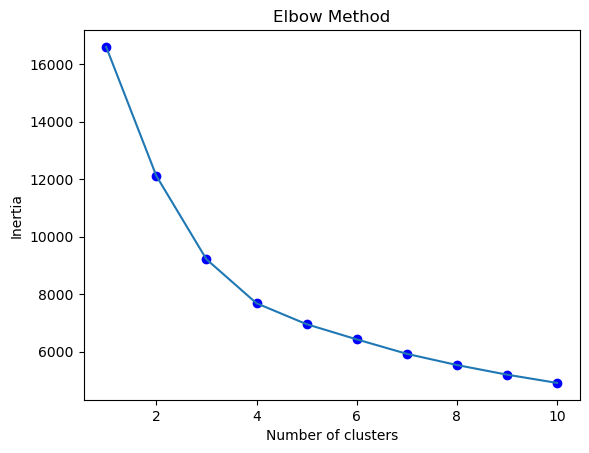

In [13]:
# Initialize an empty list to store the inertia values
inertia = []

# Define the range of clusters to test
k_range = range(1, 11)

# Loop through each value of k in the range and fit the model
for k in k_range:
    model = KMeans(n_clusters=k)
    model.fit(df_match_clustering)
    
    # Append the inertia value to the list
    inertia.append(model.inertia_)

    # Plot the k value and inertia value as a scatter point
    plt.scatter(k, model.inertia_, color='blue')

# Plot the elbow curve to find the optimal number of clusters
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [14]:
# Initialize the KMeans model with n_clusters=3
model = KMeans(n_clusters=3, random_state=notebook_seed)

# Fit the model to the data
model.fit(df_match_clustering)

# Predict the cluster labels for each data point
labels = model.predict(df_match_clustering)

#### Cluster Visualization

In [15]:
# initialize the PCA object with the number of components you want to keep
pca = PCA(n_components=2)

# fit the PCA model to the data
pca.fit(df_match_clustering)

# transform the data into the new PCA space
transformed_data = pca.transform(df_match_clustering)

# create a new dataframe with the transformed data
df_pca = pd.DataFrame(transformed_data, columns=['PC1', 'PC2'])

pc1 = pca.explained_variance_ratio_[0]
pc2 = pca.explained_variance_ratio_[1]
print(f"PC1: {round(pc1 * 100, 2)}%")
print(f"PC2: {round(pc2 * 100, 2)}%")
print(f"Total Percent Explained: {round((pc1 + pc2) * 100, 2)}%")

PC1: 39.56%
PC2: 39.18%
Total Percent Explained: 78.74%


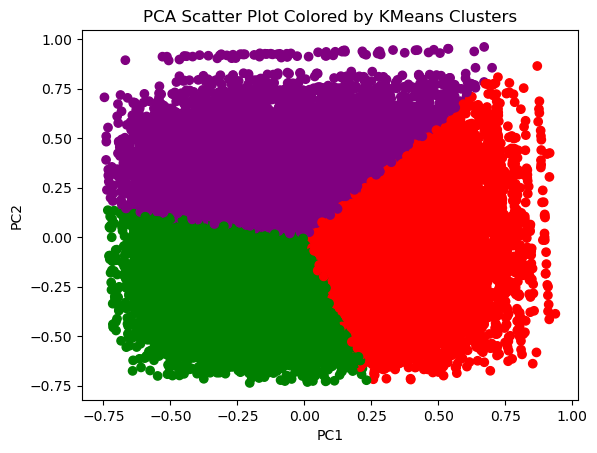

In [16]:
# define a list of colors, one for each cluster label
colors = ['Green', 'Red', 'Purple']

# map cluster labels to colors using the list of colors
color_labels = [colors[label] for label in labels]

# Plot clustering results
plt.scatter(df_pca.PC1, df_pca.PC2, c=color_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot Colored by KMeans Clusters')
plt.show()

In [17]:
# Save labels in df
df_train_match_clustering_analysis['labels_match'] = labels

# Group by label
cluster_statistics = df_train_match_clustering_analysis.groupby('labels_match').mean().reset_index()
cluster_statistics

,labels_match,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,winner_binary,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
0,0,3.698580,1401.620607,1404.429793,5.429680e+06,39.744470,0.370531,0.500588,3.767611,1404.536829,1408.825541,5.503367e+06,39.920027,0.374744,0.450267,0.193207,0.005138,0.339269,0.012120,0.904142,0.095858,0.452934,0.187873,0.004628,0.342446,0.012120,0.453601,0.191363,0.008943,0.333974,0.012120
1,1,4.794724,1457.535378,1459.304225,6.386487e+06,40.718407,0.453913,0.730573,8.354936,1602.248378,1601.237100,9.959801e+06,42.984204,0.681102,0.441256,0.183647,0.005639,0.356597,0.012861,0.851885,0.148115,0.442955,0.178897,0.005446,0.359841,0.012861,0.443882,0.177236,0.005562,0.360459,0.012861
2,2,8.420867,1600.620711,1599.180688,9.743322e+06,43.306198,0.678306,0.252691,4.603381,1449.449233,1451.938994,6.280150e+06,40.621372,0.441808,0.441150,0.175831,0.004974,0.366310,0.011735,0.852497,0.147503,0.437731,0.180493,0.005013,0.364873,0.011890,0.439557,0.182670,0.007772,0.358073,0.011929


In [18]:
# Assign meaningfull labels
cluster_names = {0: 'Boring', 1: 'Moderate', 2: 'Exciting'}
cluster_statistics['labels_match'] = cluster_statistics['labels_match'].replace(cluster_names)
cluster_statistics

,labels_match,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,winner_binary,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
0,Boring,3.698580,1401.620607,1404.429793,5.429680e+06,39.744470,0.370531,0.500588,3.767611,1404.536829,1408.825541,5.503367e+06,39.920027,0.374744,0.450267,0.193207,0.005138,0.339269,0.012120,0.904142,0.095858,0.452934,0.187873,0.004628,0.342446,0.012120,0.453601,0.191363,0.008943,0.333974,0.012120
1,Moderate,4.794724,1457.535378,1459.304225,6.386487e+06,40.718407,0.453913,0.730573,8.354936,1602.248378,1601.237100,9.959801e+06,42.984204,0.681102,0.441256,0.183647,0.005639,0.356597,0.012861,0.851885,0.148115,0.442955,0.178897,0.005446,0.359841,0.012861,0.443882,0.177236,0.005562,0.360459,0.012861
2,Exciting,8.420867,1600.620711,1599.180688,9.743322e+06,43.306198,0.678306,0.252691,4.603381,1449.449233,1451.938994,6.280150e+06,40.621372,0.441808,0.441150,0.175831,0.004974,0.366310,0.011735,0.852497,0.147503,0.437731,0.180493,0.005013,0.364873,0.011890,0.439557,0.182670,0.007772,0.358073,0.011929


In [19]:
# Save labels in dataframe
df_train['labels_match'] = labels
df_train['labels_match'] = df_train['labels_match'].replace(cluster_names)
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X,labels_match
0,0.283186,0.244477,0.245588,0.009524,0.440476,0.29,0.281818,0.320000,0.321006,0.019995,0.569767,0.40,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Boring
1,0.309735,0.534610,0.532353,0.012758,0.607143,0.54,0.281818,0.202963,0.201183,0.014244,0.581395,0.35,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Exciting
2,0.283186,0.197349,0.188235,0.011466,0.583333,0.28,0.281818,0.219259,0.213018,0.010187,0.569767,0.30,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Boring
3,0.309735,0.630339,0.642647,0.009740,0.416667,0.67,0.281818,0.481481,0.486686,0.013561,0.383721,0.50,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Exciting
4,0.292035,0.293078,0.298529,0.007673,0.273810,0.29,0.300000,0.555556,0.557692,0.017986,0.348837,0.65,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Moderate


#### Predicting Match Cluster

In [20]:
# Split data into training and test sets
match_label_X_train, match_label_X_test, match_label_y_train, match_label_y_test = train_test_split(df_train.drop('labels_match', axis=1), df_train['labels_match'], 
                                                                                                    test_size=test_train_split_percentage, 
                                                                                                    random_state=notebook_seed)

# Select columns for xgboost
match_label_X_train = match_label_X_train[machine_learning_columns]
match_label_X_test = match_label_X_test[machine_learning_columns]

# Convert categorical labels to numerical labels
transform_match_label_y = {'Boring': 0, 'Moderate': 1, 'Exciting': 2}
match_label_y_train = match_label_y_train.map(transform_match_label_y)
match_label_y_test = match_label_y_test.map(transform_match_label_y)

# Define model
match_label_xgb = xgb.XGBClassifier()

# define the parameter grid
params = {
    'objective': ['multi:softmax'], 
    'num_class': [3],
    'max_depth': [2],
    'learning_rate': [1],
    'n_estimators': [300]
}

# define the GridSearchCV object
match_label_grid_search = GridSearchCV(
    estimator=match_label_xgb, 
    param_grid=params, 
    cv=3, 
#     scoring='accuracy',
    n_jobs=-1
)

# fit the GridSearchCV object to the training data
match_label_grid_search.fit(match_label_X_train, match_label_y_train)

# Print model fit
print("[INFO] -- Match Label Model Fit")

[INFO] -- Match Label Model Fit


In [21]:
# print the best hyperparameters, their corresponding scores, and the test results
print("Best parameters found: ", match_label_grid_search.best_params_)
print("Best score: ", match_label_grid_search.best_score_)

# Get test accuracy
best_match_label_model = match_label_grid_search.best_estimator_
match_label_y_pred = best_match_label_model.predict(match_label_X_test)
match_label_test_accuracy = np.mean(match_label_y_pred == match_label_y_test)

print("Test accuracy: ", match_label_test_accuracy)

Best parameters found:  {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 300, 'num_class': 3, 'objective': 'multi:softmax'}
Best score:  0.9921391293072709
Test accuracy:  0.9930632090761751


### Fighter Clustering

#### Get all fighters dataframe

In [22]:
# Home fighter
df_home_fighter = df_all_fighter_clustering[[
    'id',
    'best_streak',
    'elo',
#     'tier_A',
#     'tier_B',
#     'tier_P',
#     'tier_S',
#     'tier_X',
#     'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
]]

# Away fighter
df_away_fighter = df_all_fighter_clustering[[
    'id_other',
    'best_streak_other',
    'elo_other',
#     'tier_other_A',
#     'tier_other_B',
#     'tier_other_P',
#     'tier_other_S',
#     'tier_other_X',
#     'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
]]

# Rename Away Fighter Columns
rename_away_fighter_df_columns = {
    'id_other': 'id',
    'best_streak_other': 'best_streak',
    'elo_other': 'elo',
    'tier_other_A': 'tier_A',
    'tier_other_B': 'tier_B',
    'tier_other_P': 'tier_P',
    'tier_other_S': 'tier_S',
    'tier_other_X': 'tier_X',
    'tier_elo_other': 'tier_elo',
    'average_bet_other': 'average_bet',
    'total_matches_other': 'total_matches',
    'win_rate_other': 'win_rate'
}
df_away_fighter.rename(columns=rename_away_fighter_df_columns, inplace=True)

In [23]:
# Get unique home fighters
df_home_fighter = df_home_fighter.drop_duplicates(subset = ["id"])

df_away_fighter = df_away_fighter.drop_duplicates(subset = ["id"])
df_away_fighter['id'] = df_away_fighter['id'].astype('int')

In [24]:
# Get df_all_fighters
df_all_fighters = pd.concat([df_home_fighter, df_away_fighter], ignore_index=True).drop_duplicates(subset = ["id"])

# Copy df for cluster analysis
df_all_fighters_cluster_analysis = df_all_fighters.copy()

# Drop id column
df_all_fighters.drop(columns=['id'], inplace=True)
df_all_fighters.head()

,best_streak,elo,average_bet,total_matches,win_rate
0,5.0,1560.0,10870713.45,44.0,0.61
1,6.0,1616.0,11638689.78,65.0,0.60
2,5.0,1463.0,7753108.92,39.0,0.56
3,6.0,1570.0,9711342.29,35.0,0.66
4,4.0,1505.0,6581680.00,39.0,0.54


In [25]:
# fit the scaler on the fighter data
scaler_fighters = MinMaxScaler()
scaler_fighters.fit(df_all_fighters)

# Transform fighter data
df_all_fighters = pd.DataFrame(scaler_fighters.transform(df_all_fighters), columns=df_all_fighters.columns)

# View df
df_all_fighters.head()

,best_streak,elo,average_bet,total_matches,win_rate
0,0.309735,0.549630,0.021055,0.511905,0.61
1,0.318584,0.632593,0.022551,0.761905,0.60
2,0.309735,0.405926,0.014983,0.452381,0.56
3,0.318584,0.564444,0.018797,0.404762,0.66
4,0.300885,0.468148,0.012702,0.452381,0.54


#### K-Means Clustering

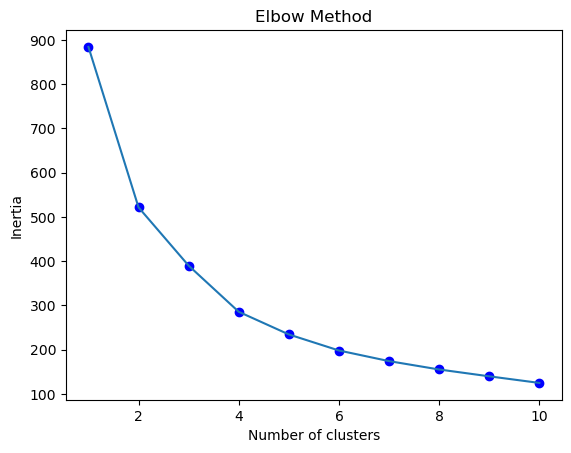

In [26]:
# Initialize an empty list to store the inertia values
inertia = []

# Define the range of clusters to test
k_range = range(1, 11)

# Loop through each value of k in the range and fit the model
for k in k_range:
    model = KMeans(n_clusters=k)
    model.fit(df_all_fighters)
    
    # Append the inertia value to the list
    inertia.append(model.inertia_)

    # Plot the k value and inertia value as a scatter point
    plt.scatter(k, model.inertia_, color='blue')

# Plot the elbow curve to find the optimal number of clusters
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [27]:
# Initialize the KMeans model with n_clusters=3
kmeans_fighters_model = KMeans(n_clusters=2, random_state=notebook_seed)

# Fit the model to the data
kmeans_fighters_model.fit(df_all_fighters)

# Predict the cluster labels for each data point
labels_fighters = kmeans_fighters_model.predict(df_all_fighters)

#### Cluster Visualization

In [28]:
# initialize the PCA object with the number of components you want to keep
pca_fighters = PCA(n_components=2)

# fit the PCA model to the data
pca_fighters.fit(df_all_fighters)

# transform the data into the new PCA space
transformed_data_fighters = pca_fighters.transform(df_all_fighters)

# create a new dataframe with the transformed data
df_pca_fighters = pd.DataFrame(transformed_data_fighters, columns=['PC1', 'PC2'])

pc1_fighters = pca_fighters.explained_variance_ratio_[0]
pc2_fighters = pca_fighters.explained_variance_ratio_[1]
print(f"PC1: {round(pc1_fighters * 100, 2)}%")
print(f"PC2: {round(pc2_fighters * 100, 2)}%")
print(f"Total Percent Explained: {round((pc1_fighters + pc2_fighters) * 100, 2)}%")

PC1: 59.69%
PC2: 34.63%
Total Percent Explained: 94.32%


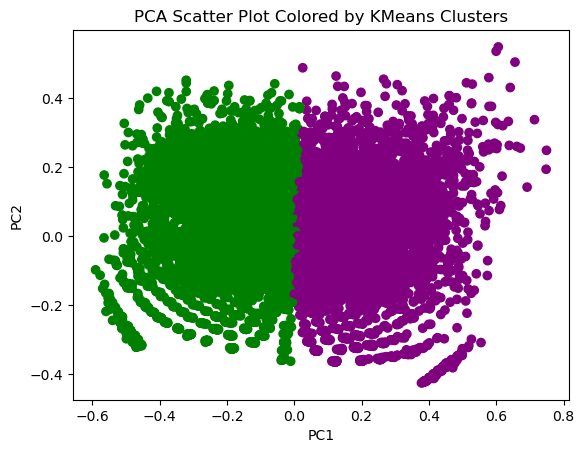

In [29]:
# define a list of colors, one for each cluster label
colors = ['Green', 'Purple']

# map cluster labels to colors using the list of colors
color_labels = [colors[label] for label in labels_fighters]

# Plot clustering results
plt.scatter(df_pca_fighters.PC1, df_pca_fighters.PC2, c=color_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot Colored by KMeans Clusters')
plt.show()

In [30]:
# Save labels in df
df_all_fighters_cluster_analysis['labels_fighters'] = labels_fighters

# Group by label
cluster_statistics_fighters = df_all_fighters_cluster_analysis.drop(columns=['id']).groupby('labels_fighters').mean().reset_index()
cluster_statistics_fighters

,labels_fighters,best_streak,elo,average_bet,total_matches,win_rate
0,0,2.787360,1407.492585,5.173956e+06,30.326261,0.328944
1,1,6.962251,1565.895408,9.460002e+06,33.701371,0.663544


In [31]:
# Assign meaningfull labels
cluster_names_fighters = {0: 'Bad', 1: 'Good'}
cluster_statistics_fighters['labels_fighters'] = cluster_statistics_fighters['labels_fighters'].replace(cluster_names_fighters)
cluster_statistics_fighters

,labels_fighters,best_streak,elo,average_bet,total_matches,win_rate
0,Bad,2.787360,1407.492585,5.173956e+06,30.326261,0.328944
1,Good,6.962251,1565.895408,9.460002e+06,33.701371,0.663544


In [32]:
# Save labels in dataframe
df_all_fighters['labels_fighter'] = labels_fighters
df_all_fighters['labels_fighter'] = df_all_fighters['labels_fighter'].replace(cluster_names_fighters)
df_all_fighters.head()

,best_streak,elo,average_bet,total_matches,win_rate,labels_fighter
0,0.309735,0.549630,0.021055,0.511905,0.61,Good
1,0.318584,0.632593,0.022551,0.761905,0.60,Good
2,0.309735,0.405926,0.014983,0.452381,0.56,Good
3,0.318584,0.564444,0.018797,0.404762,0.66,Good
4,0.300885,0.468148,0.012702,0.452381,0.54,Good


#### Predicting Match Cluster

In [33]:
# Split data into training and test sets
fighter_label_X_train, fighter_label_X_test, fighter_label_y_train, fighter_label_y_test = train_test_split(df_all_fighters.drop('labels_fighter', axis=1), df_all_fighters['labels_fighter'], 
                                                                                                    test_size=test_train_split_percentage, 
                                                                                                    random_state=notebook_seed)

# Choose columns
columns_fighter_label_prediction = [
    'best_streak',
    'elo',
    'average_bet',
    'total_matches',
    'win_rate'
]

# Select columns for xgboost
fighter_label_X_train = fighter_label_X_train[columns_fighter_label_prediction]
fighter_label_X_test = fighter_label_X_test[columns_fighter_label_prediction]

# Convert categorical labels to numerical labels
transform_fighter_label_y = {'Bad': 0, 'Good': 1}
fighter_label_y_train = fighter_label_y_train.map(transform_fighter_label_y)
fighter_label_y_test = fighter_label_y_test.map(transform_fighter_label_y)

# Define model
fighter_label_xgb = xgb.XGBClassifier()

# define the parameter grid
params_fighter_label = {
    'max_depth': [5],
    'learning_rate': [0.1],
    'n_estimators': [300]
}

# define the GridSearchCV object
fighter_label_grid_search = GridSearchCV(
    estimator=fighter_label_xgb, 
    param_grid=params_fighter_label, 
    cv=10, 
    scoring='roc_auc',
    n_jobs=-1
)

# fit the GridSearchCV object to the training data
fighter_label_grid_search.fit(fighter_label_X_train, fighter_label_y_train)

# Print model fit
print("[INFO] -- Fighter Label Model Fit")

[INFO] -- Fighter Label Model Fit


In [34]:
# print the best hyperparameters, their corresponding scores, and the test results
print("Best parameters found: ", fighter_label_grid_search.best_params_)
print("Best score: ", fighter_label_grid_search.best_score_)

# Get test accuracy
best_fighter_label_model = fighter_label_grid_search.best_estimator_
match_fighter_y_pred = best_fighter_label_model.predict(fighter_label_X_test)
fighter_label_test_accuracy = np.mean(match_fighter_y_pred == fighter_label_y_test)

print("Test accuracy: ", fighter_label_test_accuracy)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score:  0.9999502514562757
Test accuracy:  0.9923932124049152


### Adding Cluster Labels

In [35]:
# Adding match labels to test and val
df_test['labels_match'] = best_match_label_model.predict(df_test[machine_learning_columns])
df_val['labels_match'] = best_match_label_model.predict(df_val[machine_learning_columns])
df_test['labels_match'] = df_test['labels_match'].map(cluster_names)
df_val['labels_match'] = df_val['labels_match'].map(cluster_names)

# Adding fighter labels
# best_fighter_label_model.predict(df_test[match_clustering_columns])

# Apply one-hot encoding to the selected columns
df_train = pd.get_dummies(df_train, columns=['labels_match'])
df_val = pd.get_dummies(df_val, columns=['labels_match'])
df_test = pd.get_dummies(df_test, columns=['labels_match'])

# Model Fitting

#### XGBoost

In [36]:
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X,labels_match_Boring,labels_match_Exciting,labels_match_Moderate
0,0.283186,0.244477,0.245588,0.009524,0.440476,0.29,0.281818,0.320000,0.321006,0.019995,0.569767,0.40,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0
1,0.309735,0.534610,0.532353,0.012758,0.607143,0.54,0.281818,0.202963,0.201183,0.014244,0.581395,0.35,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0
2,0.283186,0.197349,0.188235,0.011466,0.583333,0.28,0.281818,0.219259,0.213018,0.010187,0.569767,0.30,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0
3,0.309735,0.630339,0.642647,0.009740,0.416667,0.67,0.281818,0.481481,0.486686,0.013561,0.383721,0.50,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0
4,0.292035,0.293078,0.298529,0.007673,0.273810,0.29,0.300000,0.555556,0.557692,0.017986,0.348837,0.65,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1


In [37]:
xgb_columns = [
    # Home fighter
    'best_streak',
    'elo',
    'tier_A',
    'tier_B',
    'tier_P',
    'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
    'tier_other_A',
    'tier_other_B',
    'tier_other_P',
    'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
    'match_format_tournament',
    'match_tier_A',
    'match_tier_B',
    'match_tier_P',
    'match_tier_S',
#     'match_tier_X', # Most common category
    
    # Cluster labels
    # Match labels
#     'labels_match_Boring', # Most common category
    'labels_match_Exciting',
    'labels_match_Moderate'
]

xgb_train = df_train[xgb_columns]
xgb_val = df_val[xgb_columns]
xgb_test = df_test[xgb_columns]

In [38]:
print("VIF of features:")
for idx, col in enumerate(list(xgb_train.columns)):
    vif = variance_inflation_factor(xgb_train, idx)
    print(f" - {col}: {vif}")

VIF of features:
 - best_streak: 131.80332391863683
 - elo: 631.5966357908717
 - tier_A: 8683.231823816217
 - tier_B: 3661.2437871439347
 - tier_P: 117.75616119485365
 - tier_S: 6878.482139653333
 - tier_elo: 533.7392968266853
 - average_bet: 3.410310661485706
 - total_matches: 34.45298030604402
 - win_rate: 100.57715743164607
 - best_streak_other: 121.34738130416297
 - elo_other: 557.1595263428893
 - tier_other_A: 34486.80199136511
 - tier_other_B: 14291.233601003365
 - tier_other_P: 583.6368276172376
 - tier_other_S: 27083.533178110927
 - tier_elo_other: 477.0311213604921
 - average_bet_other: 3.3739216558639615
 - total_matches_other: 33.59364751160567
 - win_rate_other: 99.7632694490826
 - match_format_tournament: 1.2043566547014315
 - match_tier_A: 43016.021962164414
 - match_tier_B: 17779.128571731027
 - match_tier_P: 508.0851695318619
 - match_tier_S: 34314.01892178589
 - labels_match_Exciting: 4.503120016430242
 - labels_match_Moderate: 4.594180557585049


In [41]:
# define the parameter grid
params = {'max_depth': [2, 3, 4],
          'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [200, 300, 400]}

# create an XGBoost classifier
clf = xgb.XGBClassifier()

# perform grid search using GridSearchCV
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=params, 
                           cv=3, 
                           scoring='roc_auc',
#                            scoring='accuracy',
                           n_jobs=-1
                          )
grid_search.fit(xgb_train, y_train)
print(f"[INFO] -- Fit model")

[INFO] -- Fit model


In [42]:
# print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best CV accuracy:', grid_search.best_score_)

# make predictions on the test data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(xgb_test)
y_pred_probs = best_model.predict_proba(xgb_test)
accuracy = np.mean(y_pred == y_test)
print('Test accuracy:', accuracy)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
Best CV accuracy: 0.796348526680395
Test accuracy: 0.7190689569330346


# CNN

In [ ]:
cnn_columns = [
    # Home fighter
    'best_streak',
    'elo',
    'tier_A',
    'tier_B',
    'tier_P',
    'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
    'tier_other_A',
    'tier_other_B',
    'tier_other_P',
    'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
    'match_format_tournament',
    'match_tier_A',
    'match_tier_B',
    'match_tier_P',
    'match_tier_S',
#     'match_tier_X', # Most common category
]

cnn_train = df_train[cnn_columns]
cnn_val = df_val[cnn_columns]
cnn_test = df_test[cnn_columns]

In [ ]:
# # Define the model architecture
# model = Sequential()
# input_shape = cnn_train.shape[1:]
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Fit the model to the training data
# model.fit(cnn_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(cnn_val, y_val))

# Make Predictions

#### Match data preparation functions

In [ ]:
# Get data for the current match
def get_current_match_data():    
    # store the response of URL
    response_match = urlopen(match_url)

    # storing the JSON response from url in data
    match_data_json = json.loads(response_match.read())

    # Define columns
    columns_match_data = {
        'best_streak': 'best_streak', # 0
        'elo': 'elo', # 1
        'tier': 'tier', # 2
        'tier_elo': 'tier_elo', # 3
        'average_bet': 'average_bet', # 4
        'total_matches': 'total_matches', # 5
        'win_rate': 'win_rate', # 6
        'match_format': 'match_format', # 7
        'match_tier': 'tier', # 8
        'best_streak_other': 'best_streak', # 9
        'elo_other': 'elo', # 10
        'tier_other': 'tier', # 11
        'tier_elo_other': 'tier_elo', # 12
        'average_bet_other': 'average_bet', # 13
        'total_matches_other': 'total_matches', # 14
        'win_rate_other': 'win_rate', # 15
    }

    data_extraction_match = list(columns_match_data.values())

    # Init match_data
    match_data = pd.DataFrame(columns = columns_match_data)

    # Define lists for data extraction
    sides = ['fighter_blue_info', 'fighter_red_info']

    temp_data = [
        match_data_json['fighter_blue_info'][data_extraction_match[0]],
        match_data_json['fighter_blue_info'][data_extraction_match[1]],
        match_data_json['fighter_blue_info'][data_extraction_match[2]],
        match_data_json['fighter_blue_info'][data_extraction_match[3]],
        match_data_json['fighter_blue_info']['stats'][data_extraction_match[4]],
        match_data_json['fighter_blue_info']['stats'][data_extraction_match[5]],
        match_data_json['fighter_blue_info']['stats'][data_extraction_match[6]],
        match_data_json[data_extraction_match[7]],
        match_data_json[data_extraction_match[8]],
        match_data_json['fighter_red_info'][data_extraction_match[9]],
        match_data_json['fighter_red_info'][data_extraction_match[10]],
        match_data_json['fighter_red_info'][data_extraction_match[11]],
        match_data_json['fighter_red_info'][data_extraction_match[12]],
        match_data_json['fighter_red_info']['stats'][data_extraction_match[13]],
        match_data_json['fighter_red_info']['stats'][data_extraction_match[14]],
        match_data_json['fighter_red_info']['stats'][data_extraction_match[15]],
    ]

    return pd.concat([match_data, pd.DataFrame([temp_data], columns = list(columns_match_data.keys()))])

# process encode columns
def process_current_data(df):
    # Blue fighter data
    df['tier_A'] = 0
    df['tier_B'] = 0
    df['tier_P'] = 0
    df['tier_S'] = 0
    
    # Red fighter data
    df['tier_other_A'] = 0
    df['tier_other_B'] = 0
    df['tier_other_P'] = 0
    df['tier_other_S'] = 0
    
    # Match data
    df['match_format_tournament'] = 0
    df['match_tier_A'] = 0
    df['match_tier_B'] = 0
    df['match_tier_P'] = 0
    df['match_tier_S'] = 0
    
    # Add to make scaling easier
    df['winner_binary'] = 0
    
    # Set correct dummy variables
    if df.tier[0] != 'X':
        df[f"tier_{df.tier[0]}"] = 1
    if df.tier_other[0] != 'X':
        df[f"tier_other_{df.tier_other[0]}"] = 1
    if df.match_format[0] != 'matchmaking':
        df[f"match_format_{df.match_format[0]}"] = 1
    if df.match_tier[0] != 'X':
        df[f"match_tier_{df.match_tier[0]}"] = 1
        
    return df

#### Make current match prediction

In [ ]:
while True:  
    try:
        while True:
            time.sleep(12)
            print('.')
            time.sleep(1)
            print('.')
            time.sleep(1)

            processed_current_match_data = process_current_data(get_current_match_data())[df_all.columns]
            std_current_match_data = pd.DataFrame(scaler.transform(processed_current_match_data), columns=df_all.columns)
            prediction = best_model.predict(std_current_match_data[xgb_columns])[0]
            probability = best_model.predict_proba(std_current_match_data[xgb_columns])[0]

            threashhold = max(probability)
            returns_calc = []
            for idx, probs in enumerate(y_pred_probs):
                home_prob = probs[0]
                away_prob = probs[1]
                ground_truth = y_test[idx]

                if (home_prob >= threashhold) and (ground_truth == 0):
                    returns_calc.append(1)
                elif (home_prob >= threashhold) and (ground_truth == 1):
                    returns_calc.append(0)
                elif (away_prob >= threashhold) and (ground_truth == 1):
                    returns_calc.append(1)
                elif (away_prob >= threashhold) and (ground_truth == 0):
                    returns_calc.append(0)

            chance_correct = float(np.mean(returns_calc))*100

            clear_output(wait=True)

            if prediction == 0:
                print(f"[INFO] -- Prediction: Blue")
                print(f"[INFO] -- Probability: {round(float(probability[0]*100), 3)}%")
                print(f"[INFO] -- Chance correct: {chance_correct}%")
            elif prediction == 1:
                print(f"[INFO] -- Prediction: Red")
                print(f"[INFO] -- Probability: {round(float(probability[1]*100), 3)}%")
                print(f"[INFO] -- Chance correct: {chance_correct}%")

            if threashhold > 0.9:
                mixer.music.play()
                time.sleep(15)
    except:
        time.sleep(5)

#### General Betting Rules of Thumb

"Probability" Threashholds:
- 50%-90%: 0
- 90%-95%: 5000
- 95%- on: Judgement
- 100%: All In YYYEEEEEHAWWWWWWW

# Calculating Returns

In [ ]:
# split the dataframe into training, validation, and testing sets
df_train_calculations, df_test_calculations = train_test_split(df, test_size=test_train_split_percentage, 
                                                               random_state=notebook_seed)
df_train_calculations, df_val_calculations = train_test_split(df_train_calculations, test_size=train_validation_split_percentage, 
                                                              random_state=notebook_seed)

# Notes

- Interacting through a twitch channel requires registering your bot with twitch first, getting an Oauth token (personalized)...

- then connecting to the twitch IRC, sending keepalive messages, and then sending your message when you'd like..

- BUT you're looking to interact with saltybet's website itself...which my bot also does....and that requires beautifulsoup for python

- but yeah, it was just beautiful soup to parse the info from the SB website. To actually interact with it and place bets, all I needed was the "socket" module. Connect to the IRC thru the socket with your creds, then post messages through the socket. All in 1 module.

- socket.recv (to read twitch chat), and socket.send (to send messages(must be in proper format))